In [1]:
from configs.SimulatedData import Proposed
import matplotlib.pyplot as plt
import numpy as np
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
from models.mtsStyleTransferV1 import ContentEncoder, Decoder, GlobalDiscriminator, LocalDiscriminator, StyleEncoder
from utils import dataLoader
from sklearn.decomposition import PCA
from models import losses




config = Proposed()
sequence_length = config.sequence_lenght_in_sample
feat_wiener = config.n_wiener
n_signals = config.n_feature
n_sample_wiener = config.n_sample_wiener
style_vector_size = config.style_vector_size

gran = config.granularity
overlap= config.overlap
bs = config.batch_size

content_dataset_path = "data/simulated_dataset/01 - Source Domain.h5"
style_datasets_path = [
    "data/simulated_dataset/output_noise/1.25.h5", 
    "data/simulated_dataset/output_noise/2.00.h5", 
    "data/simulated_dataset/output_noise/2.50.h5"]


2024-09-01 11:42:17.737025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 11:42:18.208489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-09-01 11:42:18.208543: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-09-01 11:42:18.208549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
# Loead Content 
content_dset_train, content_dset_valid = dataLoader.loading_wrapper(
    content_dataset_path,
    sequence_length, 
    gran, 
    overlap, 
    2*bs) # Two Times BS for the training function.

seed_content_valid = dataLoader.get_batches(content_dset_valid, 50)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [3]:
# Load Styles:
style_seeds_train, style_seeds_valid = [], []
for i, style_path in enumerate(style_datasets_path):

    style_labels = tf.zeros((1,)) + i

    style_train, style_valid =  dataLoader.loading_wrapper(
        style_path, 
        sequence_length, 
        gran, 
        overlap,
        0)
    
    _style_seed_train = dataLoader.get_batches(style_train.batch(bs), 50)
    _style_seed_valid = dataLoader.get_batches(style_valid.batch(bs), 50)

    style_seeds_train.append(_style_seed_train)
    style_seeds_valid.append(_style_seed_valid)

style_seeds_train = tf.convert_to_tensor(style_seeds_train)
style_seeds_valid = tf.convert_to_tensor(style_seeds_valid)

style_seeds_train.shape

TensorShape([3, 1000, 64, 7])

In [4]:
content_encoder = ContentEncoder.make_content_encoder(sequence_length, n_signals, feat_wiener)
style_encoder = StyleEncoder.make_style_encoder(sequence_length, n_signals, style_vector_size)
decoder = Decoder.make_generator(n_sample_wiener, feat_wiener, style_vector_size ,n_signals)

/home/henri/anaconda3/envs/tf2/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


(3000, 16, 2) (3000, 16)


No handles with labels found to put in legend.


(3000, 64, 7) (3000, 16)


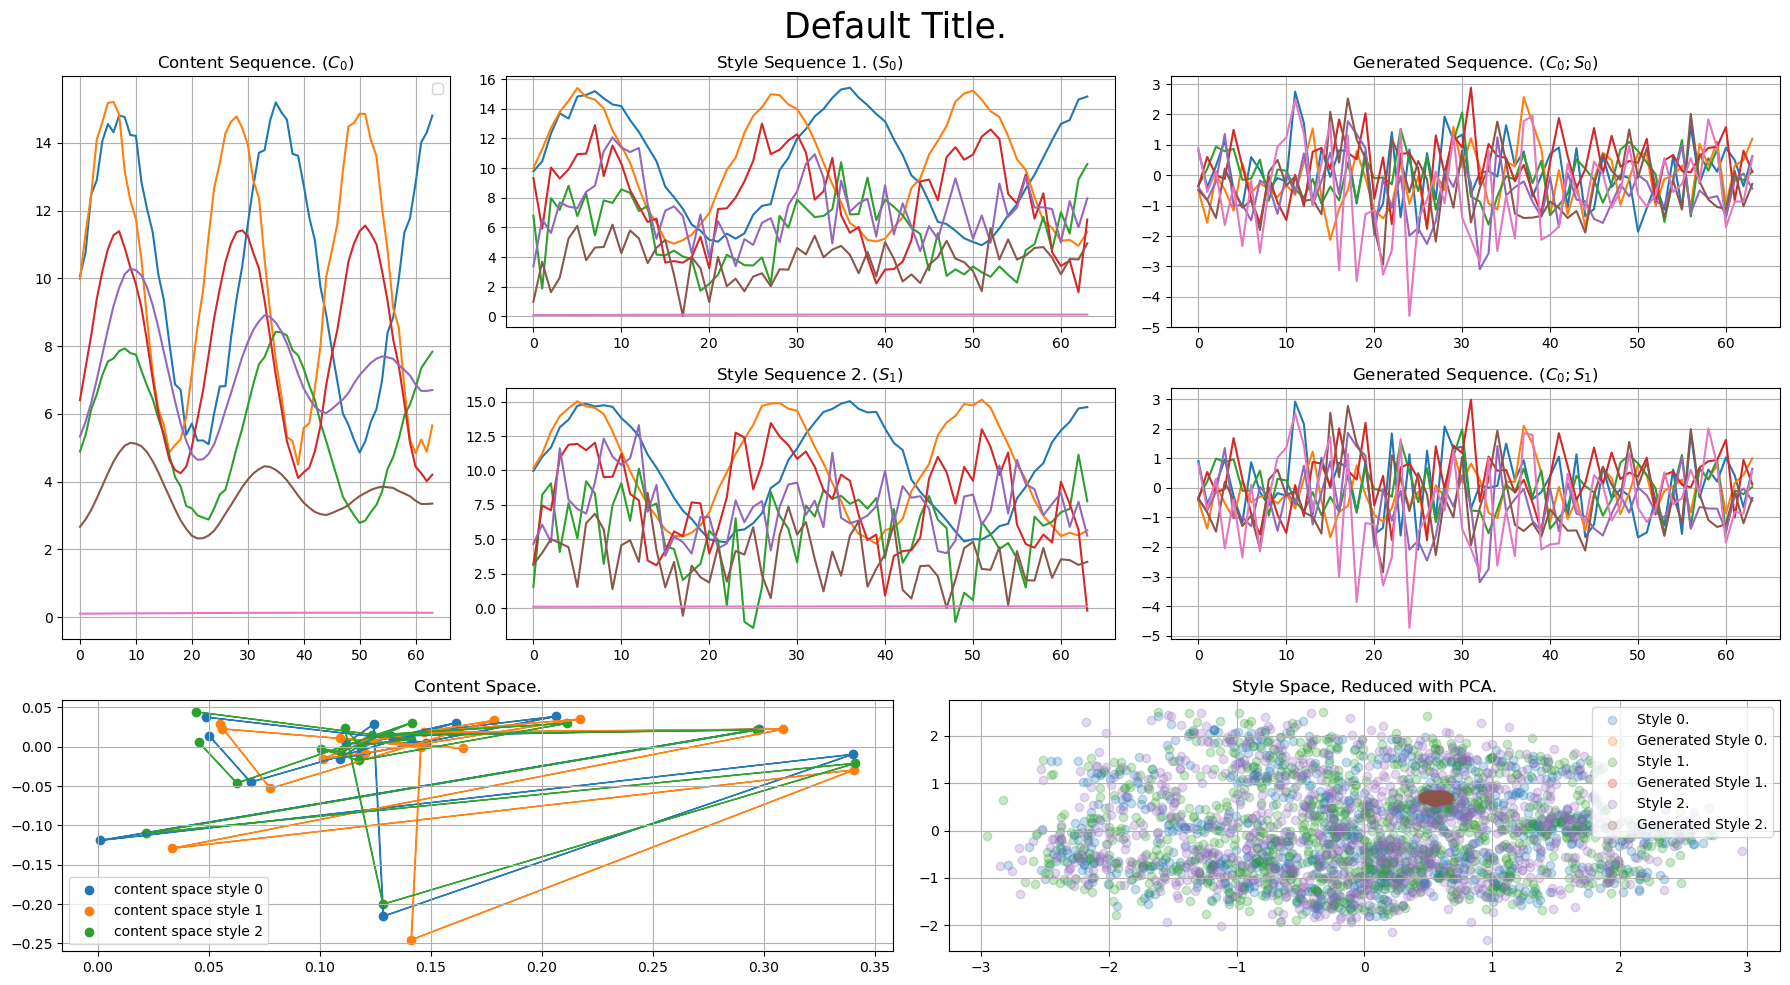

In [12]:
def draw_arrow(A, B, ax:plt.Axes, color="b", width=0.001):
    ax.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              length_includes_head=True, color=color, width=width, alpha=0.95, head_width=width*4.0)
    
def draw_arrows(xs, ys, ax:plt.Axes, color="b"):
    # points = np.stack((xs, ys)).T
    # dist = points[1:] - points[:-1]

    # norms = np.linalg.norm(dist, axis=1)
    # norm = np.mean(norms)

    for i in range(xs.shape[0]-1):
        point0 = [xs[i], ys[i]]
        point1 = [xs[i+1], ys[i+1]]
        draw_arrow(point0, point1, ax, color=color, width=0.00025)
        
        
def draw_content_space(
    ax:plt.Axes,
    content_wiener_process:tf.Tensor,
    color='tab:blue',
    label='An amayzing label.'):
    
    ax.scatter(content_wiener_process[:, 0], content_wiener_process[:, 1], label=label)
    draw_arrows(content_wiener_process[:, 0], content_wiener_process[:, 1], ax, color)
    
    
    


def plot_generated_sequence(
        content_encoder, style_encoder, decoder, 
        content_sequences, 
        seed_style_sequences:tf.Tensor, title="Default Title."):
    
    # seed style sequence:
    # Shape [n_style, nsequence, nfeat]

    # Generate viz for plots 
    style_index = 0
    n_style = seed_style_sequences.shape[0]
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    c = np.array([content_sequences[0]])
    c = content_encoder(c)
    content_encoded = tf.concat([c, c, c], 0)
    
    reshaped_style_sequences = tf.reshape(seed_style_sequences, (-1, seed_style_sequences.shape[-2], seed_style_sequences.shape[-1]))

    style_encoded = style_encoder(reshaped_style_sequences)
    
    pca = PCA(2)
    
    reduced_style = pca.fit_transform(style_encoded)
    
    reduced_style = tf.reshape(reduced_style, (
        seed_style_sequences.shape[0],
        style_encoded.shape[0]//seed_style_sequences.shape[0], 
        -1))
    
    reshaped_style_encoded = tf.reshape(style_encoded, (
        seed_style_sequences.shape[0],
        style_encoded.shape[0]//seed_style_sequences.shape[0], 
        -1))

    generated_viz = decoder([content_encoded, reshaped_style_encoded[:, style_index, :]])
    
    generated_viz = tf.concat(generated_viz, -1)
    
    content_of_generated_viz = content_encoder(generated_viz)
    
    
    # Make point for Style Scatter plot. 
    c1s = np.array([c[0]]* reshaped_style_sequences.shape[0])
    
    print(c1s.shape, style_encoded.shape)
    
    gen_c1_s = decoder([c1s, style_encoded])
    gen_c1_s = tf.concat(gen_c1_s, -1)
    
    style_of_generated_viz = style_encoder(gen_c1_s)
    
    reduced_style_of_generated_viz = pca.transform(style_of_generated_viz)
    print(gen_c1_s.shape, style_of_generated_viz.shape)
        
    reduced_style_of_generated_viz = tf.reshape(reduced_style_of_generated_viz, (
        seed_style_sequences.shape[0],
        style_encoded.shape[0]//seed_style_sequences.shape[0], 
        -1))
    
    
    
    fig = plt.figure(figsize=(18, 10))
    fig.suptitle(title, fontsize=25)
    spec= fig.add_gridspec(3, 8)
    
    
    ax00 = fig.add_subplot(spec[0:2, :2])
    ax00.set_title('Content Sequence. ($C_0$)')
    ax00.plot(content_sequences[0])
    ax00.grid(True)
    ax00.legend()

# #######
    ax01 = fig.add_subplot(spec[0, 2:5])
    ax01.set_title('Style Sequence 1. ($S_0$)')
    ax01.plot(seed_style_sequences[0, style_index, :])
    ax01.grid(True)

    ax11 = fig.add_subplot(spec[1, 2:5])
    ax11.set_title("Style Sequence 2. ($S_1$)")
    ax11.plot(seed_style_sequences[1, style_index, :])
    ax11.grid(True)

# #######
    ax02 = fig.add_subplot(spec[0, 5:])
    ax02.set_title('Generated Sequence. ($C_0; S_0$)')
    ax02.plot(generated_viz[0])
    ax02.grid(True) 

    ax12 = fig.add_subplot(spec[1, 5:])
    ax12.set_title('Generated Sequence. ($C_0; S_1$)')
    ax12.plot(generated_viz[1])
    ax12.grid(True) 
    
    
    ax10 = fig.add_subplot(spec[2, :4])
    ax10.set_title('Content Space.')
    
    ax11 = fig.add_subplot(spec[2, 4:])
    ax11.set_title('Style Space, Reduced with PCA.')   
     
    for i in range(n_style):
        draw_content_space(ax10, content_of_generated_viz[i], color=colors[i], label=f"content space style {i}")
        ax11.scatter(reduced_style[i, :, 0], reduced_style[i,:, 1], label=f'Style {i}.', alpha=0.25)
        ax11.scatter(
            reduced_style_of_generated_viz[i, :, 0], 
            reduced_style_of_generated_viz[i,:, 1], 
            label=f'Generated Style {i}.', alpha=0.25)
        
        
        
        
    ax10.legend()
    ax11.legend()
        
    
    
    
    ax10.grid()    
    ax11.grid()
    
    plt.tight_layout()
    


plot_generated_sequence(content_encoder, style_encoder, decoder, seed_content_valid, style_seeds_valid)
